In [1]:

# import the package needed to solve the environnement

from scipy.optimize import linear_sum_assignment #hungarian matching algorithm
import numpy as np
from scipy.stats import beta, bernoulli,norm
import matplotlib.pyplot as plt
%matplotlib inline

# Thompson Sampling on bipartite graph

In [2]:
# Create the bipartite graph matching environnement
class bpgraph():
    """
    create the bp graph used in the experiment. Can be improved to receive graph parameter if needed
    n is the number of vertex of the first groupe
    
    sample from a random variable of law bernoulli, or gaussian 
    
    """ 
    def __init__(self,n, example = "ex1",random_variable = "bernoulli",eps = 0.1):
        self.d = n*n
        self.m = n
        self.n = n
        self.example = example
        self.random_variable = random_variable
        self.eps = eps
        
        #adjacency matrix
        self.adjacency_matrix = np.ones((n,n)) 
        
        # weight mean of the law matrix
        if self.example == "ex1":
            self.weight_matrix = np.ones((n,n))*(1-eps)
            self.weight_matrix[np.arange(n),np.arange(n)] = 1
        elif self.example == "ex2":
            A = np.arange(n)
            B = np.arange(n).reshape(-1,1)
            self.weight_matrix = 1-eps**np.abs(A-B)
            self.weight_matrix[np.arange(n),np.arange(n)] = 1
        elif self.example == "ex3":
            A = np.arange(n)
            B = np.arange(n).reshape(-1,1)
            self.weight_matrix = 1-eps**np.maximum(np.abs(A-B),0)
            self.weight_matrix[np.arange(n),np.arange(n)] = 1
        elif self.example == "ex4":
            self.weight_matrix = np.eye(3)
            self.weight_matrix += np.eye(3,k=1)*(1-eps)
            self.weight_matrix += np.eye(3,k=-2)*(1-eps)
            
            
    def draw(self, arm_played):
        """
        Draw a vector of reward in a dict
        Also return the regret of that choice
        
        """
        reward_dict = dict()
        regret = 0
        # we assume for the moment that all arm are independent
        for i in arm_played:
            if self.random_variable == "bernoulli":
                reward_dict[tuple(i)] = bernoulli.rvs(self.weight_matrix[tuple(i)])
            elif self.random_variable == "gaussian":
                reward_dict[tuple(i)] = norm.rvs(self.weight_matrix[tuple(i)])
                
            
            regret += 1-self.weight_matrix[tuple(i)]
            
        return reward_dict, regret
    
    def compute_bound(self):
        """
        for each non optimal item compute the decision that contain this item and that have the smallest delta
        Then compute the upper bound given by thomson sampling and the "hypothetic bound" of graves and lay
        """
        c = 0
        for i in range(self.n):
            for j in range(self.n):
                if i != j:
                    delta = n-self.weight_matrix[i,j]
                    partial_matrix = np.delete(self.weight_matrix, i,0)
                    partial_matrix = np.delete(partial_matrix, j,1)
                    row_ind, col_ind = linear_sum_assignment(-partial_matrix) 
                    arm_played = np.concatenate([row_ind[:,None], col_ind[:,None]],axis=1)
                    for k,l in arm_played:
                        delta -= partial_matrix[k,l]
                elif i==j:
                    delta = 0
                    matrix = self.weight_matrix.copy()
                    matrix[i,i] = 100
                    for k in range(self.n):
                        if k !=i:
                            temp = n
                            partial_matrix = matrix.copy()
                            partial_matrix[k,k] = -100
                            row_ind, col_ind = linear_sum_assignment(-partial_matrix) 
                            arm_played = np.concatenate([row_ind[:,None], col_ind[:,None]],axis=1)
                            for k,l in arm_played:
                                temp -= self.weight_matrix[k,l]
                            if delta < temp:
                                delta = temp            
                c += 1/delta
        return c
                    
                
    
#delta_min
# 2*(1-2/(4d+1))

In [3]:
# Create Thompson sampling algorithm
n = 10
d = n**2

class CThompson_sampling():
    """
    Only for the bipartite matching (for the moment)
    """
    def __init__(self, n, example = "ex1", random_variable = "beta",weight_matrix = None):
        
        self.iteration = 0
        self.n = n
        self.d = n**2
        self.weight_matrix = weight_matrix
        
        
        self.random_variable = random_variable
        self.example = example
        self.post_param = dict()
        self.playhist = []
        self.number_item_played = dict()
        
        
        
        # Construct the dictionnary of parameter (could store all the parameter in a matrix n*n*2) 
        # but here for being more modulable it will be on 
        for i in range(n):
            for j in range(n):
                if self.random_variable == "beta":
                    self.post_param[i,j] = np.array([1.,1.]) # prior is 1,1 for the beta law of each arm
                elif self.random_variable == "gaussian": 
                    self.post_param[i,j] = np.array([0.,0.])
                self.number_item_played[i,j] = 0.
        
        self.weight_draw = np.zeros((n,n))
         
    def reset(self):
        self.iteration = 0
        # Construct the dictionnary of parameter (could store all the parameter in a matrix n*n*2) 
        # but here for being more modulable it will be on 
        for i in range(n):
            for j in range(n):
                if self.random_variable == "beta":
                    self.post_param[i,j] = np.array([1.,1.]) # prior is 1,1 for the beta law of each arm
                elif self.random_variable == "gaussian": 
                    self.post_param[i,j] = np.array([0.,0.])
                self.number_item_played[i,j] = 0.
        
        
        self.weight_draw = np.zeros((n,n))
        
        
        
    def play(self):
        """
        This will drow a sample (arm played) using the parameters 

        """
        for i in range(self.n):
            for j in range(self.n):
                if self.random_variable == "beta":
                    if self.example != "ex5":
                        self.weight_draw[i,j] = beta.rvs(self.post_param[(i,j)][0],self.post_param[(i,j)][1])
                    else : 
                        self.weight_draw[i,j] = self.weight_matrix[i,j]
                        if i == j:
                            self.weight_draw[i,j] = beta.rvs(self.post_param[(i,j)][0],self.post_param[(i,j)][1])
                            
                elif self.random_variable == "gaussian": 
                    self.weight_draw[i,j] = norm.rvs(self.post_param[(i,j)][0],self.post_param[(i,j)][1])
                    


        row_ind, col_ind = linear_sum_assignment(-self.weight_draw) 
        # we have to maximize the reward (the scypy implementation minimizes the cast)

        arm_played = np.concatenate([row_ind[:,None], col_ind[:,None]],axis=1)
        #Trick to have the list of the arm played
        
        self.playhist.append(arm_played)

        return arm_played


    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration +=1
        for key, valu in observation.items():
            self.number_item_played[key] += 1
            if self.random_variable == "beta":
                y = bernoulli.rvs(valu)
                self.post_param[key][0] += y  #alpha update
                self.post_param[key][1] += 1-y  #beta update
            elif self.random_variable == "gaussian": 
                self.post_param[key][0] = (self.post_param[key][0]*(self.number_item_played[key]-1)+valu)/self.number_item_played[key]
                self.post_param[key][1] = 1/np.sqrt(self.number_item_played[key])

                            
               

0

# Experiments on TS

In [4]:
# Parameters of the experiments
random_variable = "gaussian"

## Example 1

In [7]:
ns = [3,5,8]
n_trial = 1
all_regrets = []

eps = 0.2


for n in ns:
    print("Thompson sampling for a graph of size {}".format(n))
    trial_regrets = []
    graph = bpgraph(n,random_variable = random_variable)
    for trial in range(n_trial):
        player = CThompson_sampling(n, random_variable = random_variable)
        n_iteration = 20000
        regrets = []
        for i in range(n_iteration):
            if i%1000 == 0:
                print("Iteration {}".format(i))
            arm_played = player.play()
            reward_dict, regret = graph.draw(arm_played)
            regrets.append(regret)
            player.update(reward_dict)
        trial_regrets.append(regrets)
        
    all_regrets.append(trial_regrets)  
    
    

Thompson sampling for a graph of size 3
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Thompson sampling for a graph of size 5
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iteration 17000
Iteration 18000
Iteration 19000
Thompson sampling for a graph of size 8
Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000
Iteration 11000
Iteration 12000
Iteration 13000
Iteration 14000
Iteration 15000
Iteration 16000
Iterati

In [98]:
print(player.post_param)

{(0, 0): array([0.79915339, 0.13363062]), (0, 1): array([0.97241426, 0.08638684]), (0, 2): array([0.64011744, 0.18569534]), (0, 3): array([0.94158065, 0.08908708]), (0, 4): array([0.81301335, 0.12598816]), (0, 5): array([0.92359602, 0.10314212]), (0, 6): array([0.92292474, 0.11043153]), (0, 7): array([0.99505613, 0.06388766]), (0, 8): array([0.82641536, 0.15075567]), (0, 9): array([0.68570232, 0.19245009]), (0, 10): array([0.61051645, 0.16666667]), (0, 11): array([0.90120456, 0.10910895]), (0, 12): array([0.95330972, 0.08333333]), (0, 13): array([0.82858785, 0.11952286]), (0, 14): array([0.76990054, 0.11952286]), (0, 15): array([0.67950381, 0.15430335]), (0, 16): array([0.83715682, 0.13483997]), (0, 17): array([0.975598  , 0.08638684]), (0, 18): array([1.02181271, 0.06741999]), (0, 19): array([0.96329282, 0.06593805]), (0, 20): array([0.74896791, 0.13867505]), (0, 21): array([0.84260932, 0.12909944]), (0, 22): array([0.89570796, 0.09578263]), (0, 23): array([1.00427563, 0.06666667]), (

[  32.79333333   77.55333333 -385.5       ]
[]
[   0.82324814   19.62136308  142.58993645 -484.28977688]
[]
[-3.54571466e-02  1.20275753e+00  1.98251278e+01  1.32008203e+02
 -4.61753182e+02]
[]


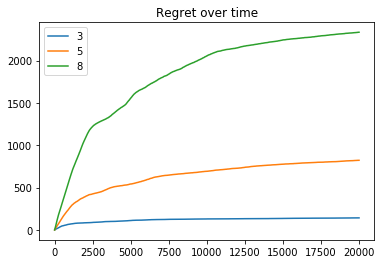

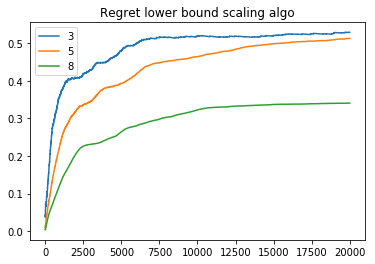

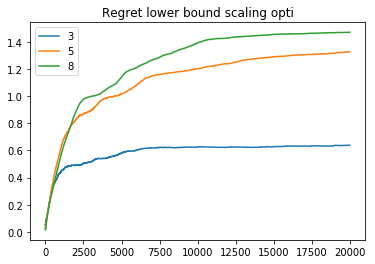

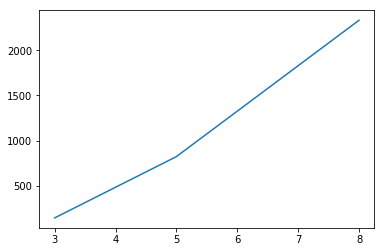

In [8]:
plt.figure(1)
final_regrets = []
plt.clf()
for i,n in enumerate(ns):
    d = n**2
    cumulative_regrets = np.mean(np.cumsum(all_regrets[i],axis = 1),axis = 0)
    C_opti = d/(2*eps)
    C = C_opti*np.log(n)**2
    Domination_constant1 = cumulative_regrets[2:]/np.log(np.arange(2,len(cumulative_regrets)))/C
    Domination_constant2 = cumulative_regrets[2:]/np.log(np.arange(2,len(cumulative_regrets)))/C_opti
    final_regrets.append(cumulative_regrets[-1])
    plt.figure(1)
    plt.plot(cumulative_regrets, label = n)
    plt.title("Regret over time")
    plt.legend()
    plt.figure(2)
    plt.plot(Domination_constant1, label = n)
    plt.title("Regret lower bound scaling algo")
    plt.legend()
    plt.figure(3)
    plt.plot(Domination_constant2, label = n)
    plt.title("Regret lower bound scaling opti")
    plt.legend()

# quand n est multiplié par 2 le regret est multiplié par 4 (si la borne de regret est bien en log(m)m^2)
# On devrait avoir une courbe en x^2 et non en x^3
plt.figure(4)
plt.clf()
plt.plot(ns,final_regrets)


# if we fit with polynomial of degree 2
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,2,full = True)
print(p)
print(residuals)

# if we fit with polynomial of degree 3
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,3,full = True)
print(p)
print(residuals)


# if we fit with polynomial of degree 4
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,4,full = True)
print(p)
print(residuals)



## Example 2 
With eps

In [50]:
ns = [2,4,8,16,32]
n_trial = 1
all_regrets = []
eps = 0.4
bound_constant = dict()

for n in ns:
    trial_regrets = []
    graph = bpgraph(n,example = "ex2", eps = eps)
    bound_constant[n] = graph.compute_bound()
    for trial in range(n_trial):
        player = CThompson_sampling(n)
        n_iteration = 300
        regrets = []
        for i in range(n_iteration):
            arm_played = player.play()
            reward_dict, regret = graph.draw(arm_played)
            regrets.append(regret)
            player.update(reward_dict)
        trial_regrets.append(regrets)
        
    all_regrets.append(trial_regrets)  

[ -0.13144918   8.6146907  -16.95609239]
[150.73116586]


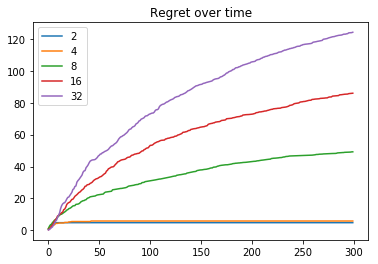

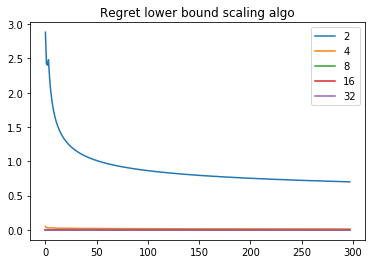

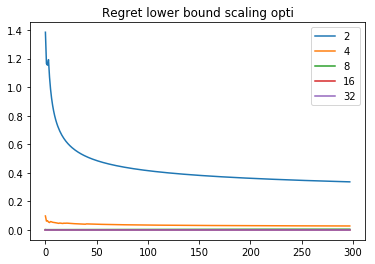

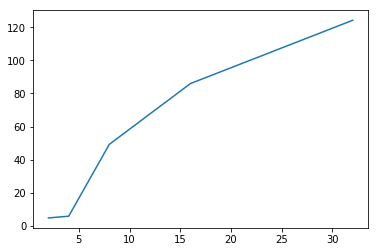

In [51]:
plt.figure(1)
final_regrets = []
plt.clf()
for i,n in enumerate(ns):
    d = n**2
    delta_min = 2*eps**(n-1)
    cumulative_regrets = np.mean(np.cumsum(all_regrets[i],axis = 1),axis = 0)
    C_opti = bound_constant[n]
    C = C_opti*np.log(n)**2
    Domination_constant1 = cumulative_regrets[2:]/np.log(np.arange(2,len(cumulative_regrets)))/C
    Domination_constant2 = cumulative_regrets[2:]/np.log(np.arange(2,len(cumulative_regrets)))/C_opti
    final_regrets.append(cumulative_regrets[-1])
    plt.figure(1)
    plt.plot(cumulative_regrets, label = n)
    plt.title("Regret over time")
    plt.legend()
    plt.figure(2)
    plt.plot(Domination_constant1, label = n)
    plt.title("Regret lower bound scaling algo")
    plt.legend()
    plt.figure(3)
    plt.plot(Domination_constant2, label = n)
    plt.title("Regret lower bound scaling opti")
    plt.legend()

# quand n est multiplié par 2 le regret est multiplié par 4 (si la borne de regret est bien en log(m)m^2)
# On devrait avoir une courbe en x^2 et non en x^3
plt.figure(4)
plt.clf()
plt.plot(ns,final_regrets)


# if we fit with polynomial of degree 2
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,2,full = True)
print(p)
print(residuals)

In [52]:
bound_constant

{2: 2.5,
 4: 37.08627681841965,
 8: 1774.6761539701292,
 16: 2689462.4687728276,
 32: 6253928900356.625}

## Example 3



In [38]:
ns = [2,4,8,16,32]
n_trial = 5
all_regrets = []
eps = 0.2

bound_constant = dict()

for n in ns:
    trial_regrets = []
    graph = bpgraph(n,example = "ex3", eps = eps)
    bound_constant[n] = graph.compute_bound()
    for trial in range(n_trial):
        player = CThompson_sampling(n)
        n_iteration = 300
        regrets = []
        for i in range(n_iteration):
            arm_played = player.play()
            reward_dict, regret = graph.draw(arm_played)
            regrets.append(regret)
            player.update(reward_dict)
        trial_regrets.append(regrets)
        
    all_regrets.append(trial_regrets)  

/Users/rzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars


[-0.0804126   4.65940484 -5.57704473]
[68.60963043]


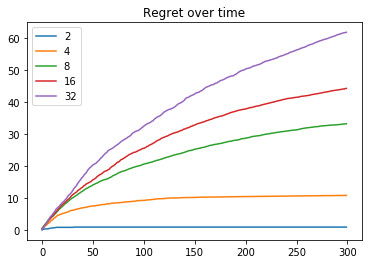

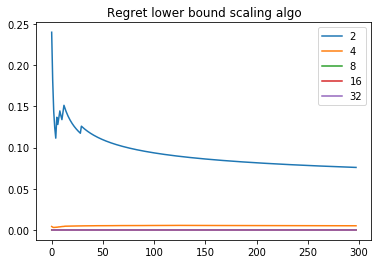

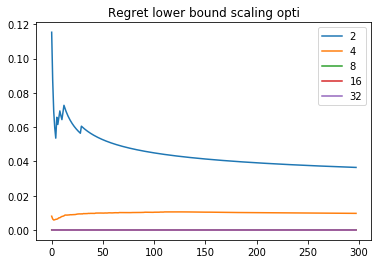

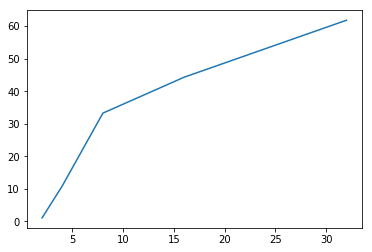

In [40]:
plt.figure(1)
final_regrets = []
plt.clf()
for i,n in enumerate(ns):
    d = n**2
    cumulative_regrets = np.mean(np.cumsum(all_regrets[i],axis = 1),axis = 0)
    C_opti = bound_constant[n]
    C = C_opti*np.log(n)**2
    Domination_constant1 = cumulative_regrets[2:]/np.log(np.arange(2,len(cumulative_regrets)))/C
    Domination_constant2 = cumulative_regrets[2:]/np.log(np.arange(2,len(cumulative_regrets)))/C_opti
    final_regrets.append(cumulative_regrets[-1])
    plt.figure(1)
    plt.plot(cumulative_regrets, label = n)
    plt.title("Regret over time")
    plt.legend()
    plt.figure(2)
    plt.plot(Domination_constant1, label = n)
    plt.title("Regret lower bound scaling algo")
    plt.legend()
    plt.figure(3)
    plt.plot(Domination_constant2, label = n)
    plt.title("Regret lower bound scaling opti")
    plt.legend()

# quand n est multiplié par 2 le regret est multiplié par 4 (si la borne de regret est bien en log(m)m^2)
# On devrait avoir une courbe en x^2 et non en x^3
plt.figure(4)
plt.clf()
plt.plot(ns,final_regrets)


# if we fit with polynomial of degree 2
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,2,full = True)
print(p)
print(residuals)

In [31]:
graph = bpgraph(10,example = "ex3", eps = 0.1)
graph.compute_bound()

14.0
13.0
12.0
11.0
10.0
9.0
8.0
7.0
6.0
14.10000001
13.10000001
12.10000001
11.10000001
10.10000001
9.10000001
8.10000001
7.1000000100000005
6.1000000110000006
14.01
13.0100001
12.0100001
11.0100001
10.0100001
9.0100001
8.0100001
7.010000099999999
6.010000100999999
14.001
13.001
12.001000999999999
11.001000999999999
10.001000999999999
9.001000999999999
8.001000999999999
7.001000999999999
6.001001000999999
14.0001
13.0001
12.0001
11.00011
10.00011
9.00011
8.00011
7.000109999999999
6.0001100009999995
14.00001
13.00001
12.00001
11.00001
10.00002
9.00002
8.00002
7.000019999999999
6.000019999999999
14.000001
13.000001
12.000001
11.000001
10.000001
9.000001999999999
8.000001999999999
7.0000019999999985
6.0000019999999985
14.0000001
13.0000001
12.0000001
11.0000001
10.0000001
9.0000001
8.000000199999999
7.000000199999999
6.000000199999999
14.00000001
13.00000001
12.00000001
11.00000001
10.00000001
9.00000001
8.00000001
7.000000020000001
6.000000020000001
14.000000001
13.000000001
12.00000000

16.61261309277102

## Example 4

Number of play for each decisions (For the 3 + 3 nodes graph)

In [4]:
n = 3
regrets = []
eps = 0.1
n_iteration = 20000

graph = bpgraph(n,example = "ex4",random_variable = random_variable, eps = eps)
player = CThompson_sampling(n,random_variable = random_variable)
for i in range(n_iteration):
            arm_played = player.play()
            reward_dict, regret = graph.draw(arm_played)
            regrets.append(regret)
            player.update(reward_dict)



NameError: name 'random_variable' is not defined

/Users/rzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/rzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


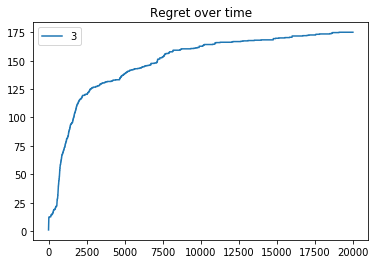

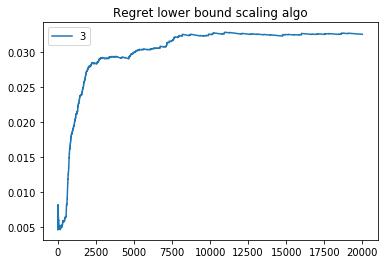

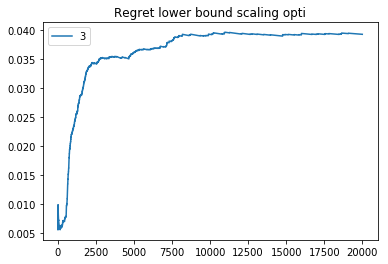

In [127]:
plt.figure(1)
final_regrets = []
plt.clf()

d = n**2
delta_min = 2*eps**(n-1)
cumulative_regrets = np.cumsum(regrets)
C = d*np.log(n)**2/delta_min
C_opti = d/delta_min
Domination_constant1 = cumulative_regrets[1:]/np.log(np.arange(1,len(cumulative_regrets)))/C
Domination_constant2 = cumulative_regrets[1:]/np.log(np.arange(1,len(cumulative_regrets)))/C_opti
final_regrets.append(cumulative_regrets[-1])
plt.figure(1)
plt.plot(cumulative_regrets, label = n)
plt.title("Regret over time")
plt.legend()
plt.figure(2)
plt.plot(Domination_constant1, label = n)
plt.title("Regret lower bound scaling algo")
plt.legend()
plt.figure(3)
plt.plot(Domination_constant2, label = n)
plt.title("Regret lower bound scaling opti")
plt.legend()





In [91]:
arm_played

array([[0, 0],
       [1, 1],
       [2, 2]])

In [29]:
cumulative_regrets[100] 

4.2

In [53]:
np.eye(3,k=-2)*(1-eps)

array([[0. , 0. , 0. ],
       [0. , 0. , 0. ],
       [0.6, 0. , 0. ]])

## Example 5
First time playing optimal arm TS





In [2]:
n = 3
regrets = []
distrib_first_optimal = []
optimal_arm = np.array([[0, 0],[1, 1],[2, 2]])
eps = 0.1
n_trial = 1000 
#n_iteration = 20000

for iteration in range(n_trial):
    if iteration%100 == 0:
        print("begin_trial {}".format(iteration))
    
    graph = bpgraph(n,example = "ex4", eps = eps)
    player = CThompson_sampling(n, example = "ex5", weight_matrix = graph.weight_matrix)
    
#    for i in range(n):
#        for j in range(n):
#            if i!=j:
#                player.post_param[i,j] = 
    optimal_arm_played = False
    counter = 0
    while not optimal_arm_played:
            arm_played = player.play()
            reward_dict, regret = graph.draw(arm_played)
            regrets.append(regret)
            player.update(reward_dict)
            counter += 1
            
            if counter%2000 == 0:
                print("Have still not played the optimal arm at time {}".format(counter))
            
            if (arm_played == optimal_arm).all():
                optimal_arm_played = True
                
                
                        
    distrib_first_optimal.append(counter)      
            
    

begin_trial 0


NameError: name 'bpgraph' is not defined

(array([517., 228., 130.,  59.,  36.,  15.,   6.,   5.,   1.,   3.]),
 array([1.0000e+00, 1.4480e+02, 2.8860e+02, 4.3240e+02, 5.7620e+02,
        7.2000e+02, 8.6380e+02, 1.0076e+03, 1.1514e+03, 1.2952e+03,
        1.4390e+03]),
 <a list of 10 Patch objects>)

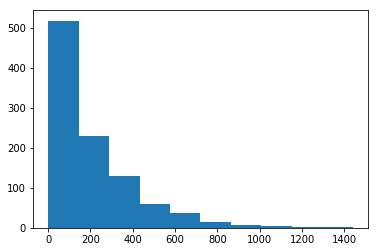

In [12]:
plt.figure(1)
plt.clf()
plt.hist(distrib_first_optimal)


## Speed Test

In [122]:
%%time
matrix = np.random.randn(50,50)
m = Munkres()
for i in range(1000): 
    indexes = m.compute(matrix)



CPU times: user 26 s, sys: 96 ms, total: 26.1 s
Wall time: 26.4 s


In [121]:
%%time
matrix = np.random.randn(50,50)
for i in range(1000):
    row_ind, col_ind = linear_sum_assignment(matrix)

CPU times: user 131 ms, sys: 3.69 ms, total: 134 ms
Wall time: 141 ms


In [86]:
A = np.arange(5)
B = np.arange(5).reshape(-1,1)
1-0.1**np.abs(A-B)

array([[0.    , 0.9   , 0.99  , 0.999 , 0.9999],
       [0.9   , 0.    , 0.9   , 0.99  , 0.999 ],
       [0.99  , 0.9   , 0.    , 0.9   , 0.99  ],
       [0.999 , 0.99  , 0.9   , 0.    , 0.9   ],
       [0.9999, 0.999 , 0.99  , 0.9   , 0.    ]])

# Exponential regret of TS on a simple case

In [2]:
class Two_decision_env():
    """
    Create an environment with 2 decisions composed of d/2 items with reward a and b with a>b>1/2
    
    """ 
    def __init__(self,d,a = 1,b = 0.9,sigma = 1,random_variable = "bernoulli"):
        self.d = d
        self.a = a
        self.b = b
        self.sigma = sigma
        
        self.random_variable = random_variable
                 
    def draw(self, decision):
        """
        Draw a vector of reward
        
        """
        if self.random_variable == "bernoulli":
            if decision == 0:
                reward = bernoulli.rvs(self.a, size = d)
            elif decision == 1:
                reward = bernoulli.rvs(self.b, size = d)
                
        elif self.random_variable == "gaussian":
            if decision == 0:
                reward = norm.rvs(self.a, scale=self.sigma, size = d)
            elif decision == 1:
                reward = norm.rvs(self.b, scale=self.sigma, size = d)
            
        if decision == 1:
            regret = (self.a-self.b)*self.d
        elif decision == 0:
            regret = 0
            
        return reward, regret

## CTS

In [3]:
class CTS_exp():
    """
    TS for the two decision environnement
    """
    def __init__(self, d,n_init = 0, post_distrib = "beta"):
        
        self.iteration = 0
        self.d = d
        
        
        self.weight_draw = np.zeros(2*d)
        self.numplayed = np.zeros(2)
        
        self.initialization = False
        
        self.n_init = n_init # sample n_init time each decision
        if self.n_init > 0:   
            self.initialization = True
        
        
        self.post_distrib = post_distrib
        self.playhist = []
        
        
        if self.post_distrib == "beta":
            self.alpha = np.ones(2*self.d)
            self.beta = np.ones(2*self.d)
        elif self.post_distrib == "gaussian":
            self.mu = np.zeros(2*self.d)
            self.sigma = np.zeros(2*self.d)
        
        

         
    def reset(self):
        self.iteration = 0
        self.weight_draw = np.zeros(2*d)
        self.numplayed = np.zeros(2)
        self.playhist = []
        
        if self.n_init > 0:   
            self.initialization = True
    
        if self.random_variable == "beta":
            self.alpha = np.ones(2*self.d)
            self.beta = np.ones(2*self.d)
        elif self.random_variable == "gaussian":
            self.mu = np.zeros(2*self.d)
            self.sigma = np.zeros(2*self.d)
        
        
    def play(self):
        """
        This will drow a sample (arm played) using the parameters 

        """
        
        if self.iteration < self.n_init:
            self.decision = 0
            self.playhist.append(self.decision)
            return(self.decision)
        
        if self.iteration < 2*self.n_init:
            self.decision = 1
            self.playhist.append(self.decision)
            return(self.decision)
        else:       
            self.initialization = False
        
            
        if self.post_distrib == "beta":
            self.weight_draw = beta.rvs(self.alpha, self.beta)
            
        elif self.post_distrib == "gaussian": 
            self.weight_draw = norm.rvs(self.mu, self.sigma)
                    
        mean_a = np.sum(self.weight_draw[:self.d])
        mean_b = np.sum(self.weight_draw[self.d:])
        if mean_a > mean_b:
            self.decision = 0
        else :
            self.decision = 1
            
            
        self.playhist.append(self.decision)

        return self.decision


    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration += 1
        self.numplayed[self.decision] += 1
        
        if self.post_distrib == "beta":
            if self.decision == 0:    
                self.alpha[:self.d] += observation
                self.beta[:self.d] += 1-observation
            elif self.decision == 1:
                self.alpha[self.d:] += observation
                self.beta[self.d:] += 1-observation
        if self.post_distrib == "gaussian":
            if self.decision == 0:    
                self.mu[:self.d] = (self.mu[:self.d]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
                self.sigma[:self.d] =  1/np.sqrt(self.numplayed[self.decision])
            elif self.decision == 1:
                self.mu[self.d:] = (self.mu[self.d:]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
                self.sigma[self.d:] =  1/np.sqrt(self.numplayed[self.decision])

In [6]:
# testing the first time optimal is played

ds = range(10,20,2)
distrib_first_optimal = []
n_trial = 1000 
a=1
b=0.995
n_init = 20
random_variable = "bernoulli"
post_distrib = "beta"

upper_limit = 200000
#n_iteration = 20000


for i,d in enumerate(ds):
    print("d = ",d)
    distrib_first_optimal.append([])
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(d,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = CTS_exp(d,n_init = n_init)

        counter = 0
        while player.initialization:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
        
        while player.decision and counter < uper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1

                if counter%2000 == 0:
                    print("Have still not played the optimal arm at time {}".format(counter))


        distrib_first_optimal[i].append(counter)   

d =  10
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900
d =  12
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900
d =  14
begin_trial 0
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the 

Have still not played the optimal arm at time 98000
Have still not played the optimal arm at time 100000
Have still not played the optimal arm at time 102000
Have still not played the optimal arm at time 104000
Have still not played the optimal arm at time 106000
Have still not played the optimal arm at time 108000
Have still not played the optimal arm at time 110000
Have still not played the optimal arm at time 112000
Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 1

d =  18
begin_trial 0
begin_trial 100
Have still not played the optimal arm at time 2000
Have still not played the optimal arm at time 4000
Have still not played the optimal arm at time 6000
Have still not played the optimal arm at time 8000
Have still not played the optimal arm at time 10000
Have still not played the optimal arm at time 12000
Have still not played the optimal arm at time 14000
Have still not played the optimal arm at time 16000
Have still not played the optimal arm at time 18000
Have still not played the optimal arm at time 20000
Have still not played the optimal arm at time 22000
Have still not played the optimal arm at time 24000
Have still not played the optimal arm at time 26000
Have still not played the optimal arm at time 28000
Have still not played the optimal arm at time 30000
Have still not played the optimal arm at time 32000
Have still not played the optimal arm at time 34000
Have still not played the optimal arm at time 36000
Have still not played the opti

Have still not played the optimal arm at time 114000
Have still not played the optimal arm at time 116000
Have still not played the optimal arm at time 118000
Have still not played the optimal arm at time 120000
Have still not played the optimal arm at time 122000
Have still not played the optimal arm at time 124000
Have still not played the optimal arm at time 126000
Have still not played the optimal arm at time 128000
Have still not played the optimal arm at time 130000
Have still not played the optimal arm at time 132000
Have still not played the optimal arm at time 134000
Have still not played the optimal arm at time 136000
Have still not played the optimal arm at time 138000
Have still not played the optimal arm at time 140000
Have still not played the optimal arm at time 142000
Have still not played the optimal arm at time 144000
Have still not played the optimal arm at time 146000
Have still not played the optimal arm at time 148000
Have still not played the optimal arm at time 

In [14]:
bins = [0,50,100,1000,5000,10000,20000]

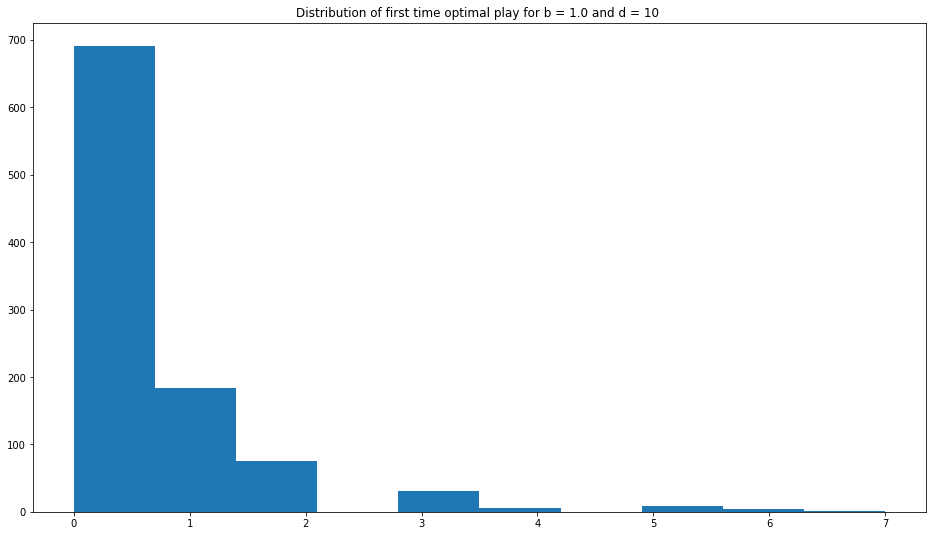

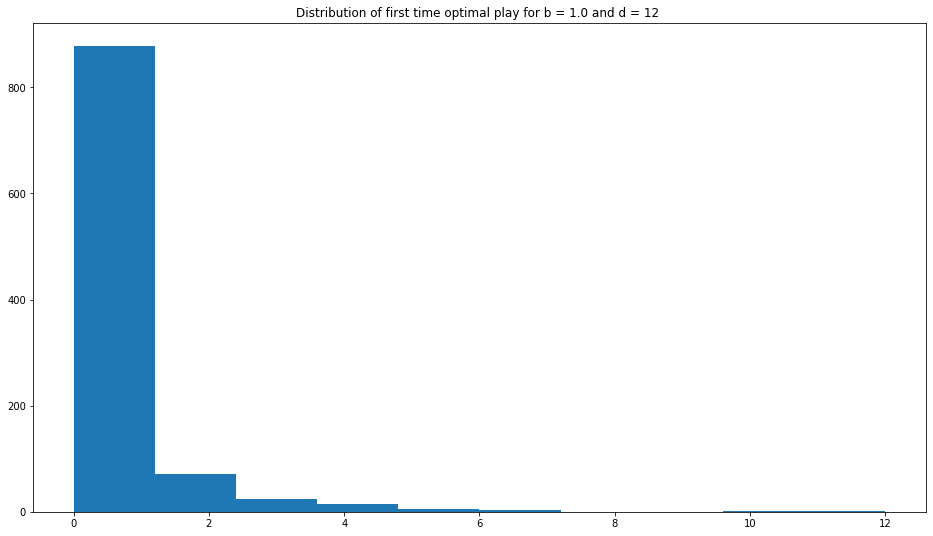

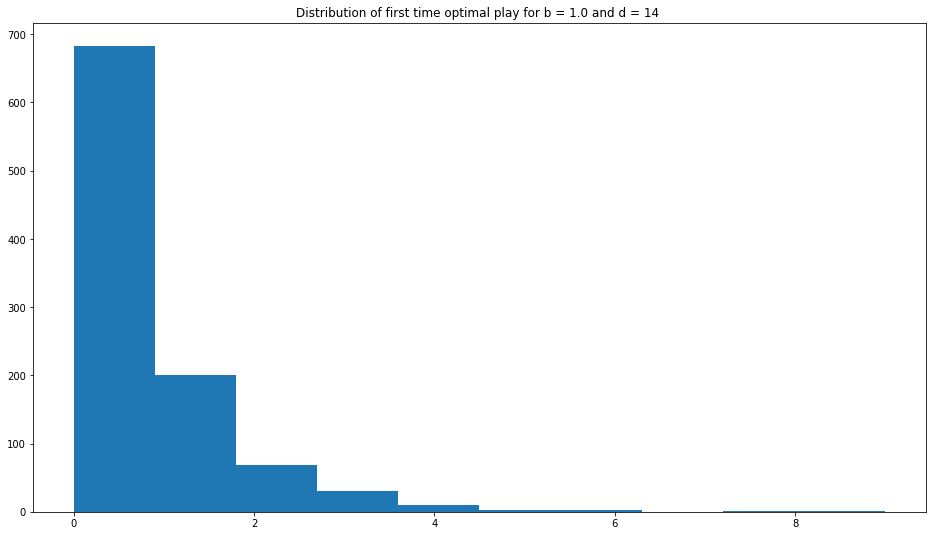

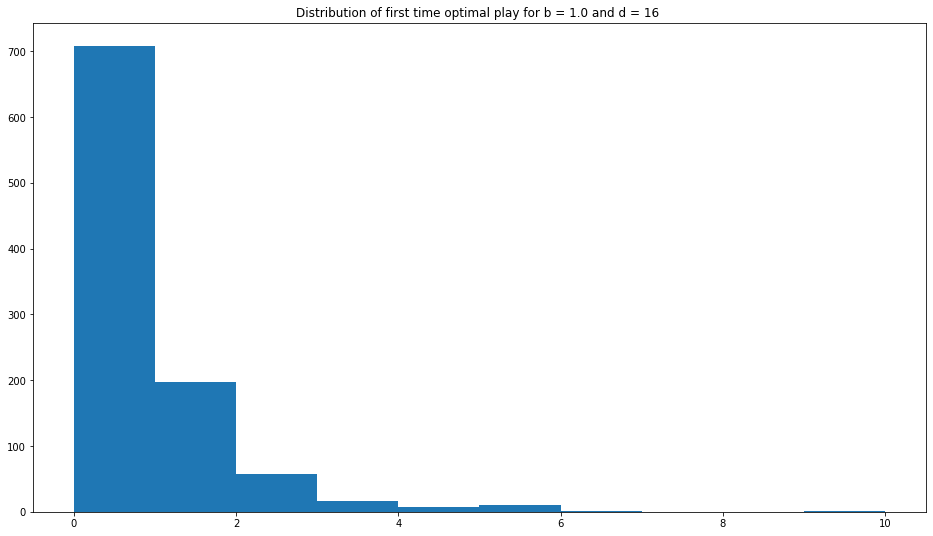

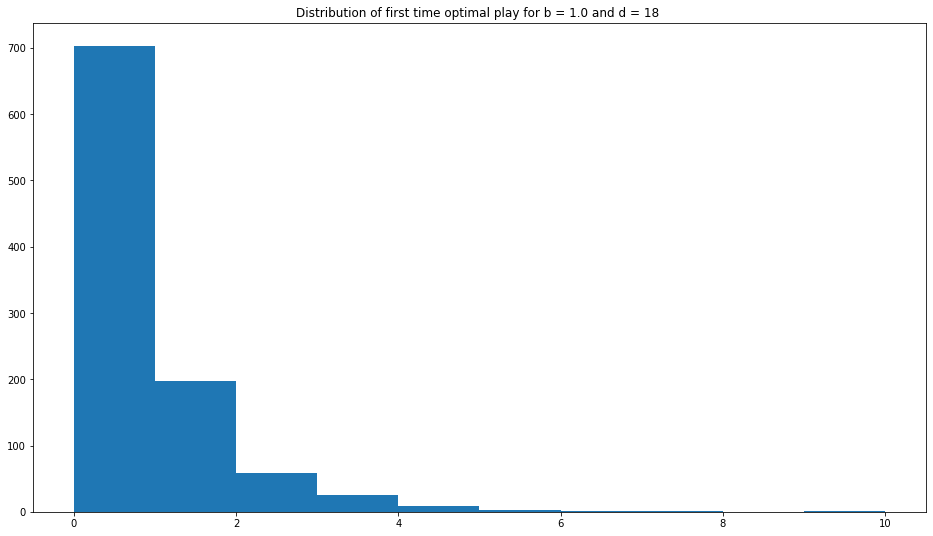

In [49]:
for i,d in enumerate(ds):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    bins  = [0]+[2] + list(np.linspace(min(distrib_first_optimal[i]),max(distrib_first_optimal[i]),11))[1:]
    plt.hist(distrib_first_optimal[i])
    plt.title("Distribution of first time optimal play for b = {:.1f} and d = {:d} ".format(b,d))

In [50]:
Average_time1 = np.mean(distrib_first_optimal, axis =1)
print(Average_time1)

[0.522 0.546 0.514 0.462 0.466]


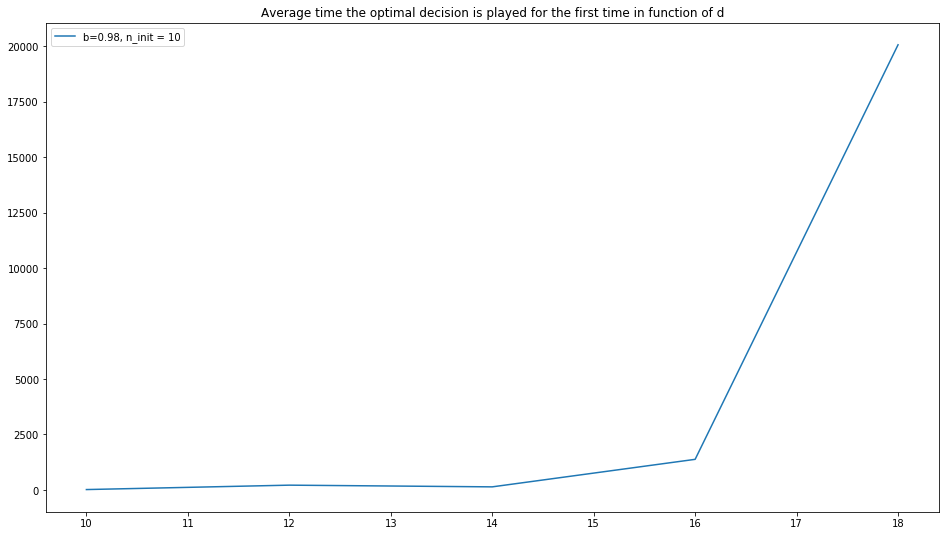

In [44]:
ds1 = range(10,20,2)
#ds2 = range(10,28,2)
#ds3 = range(6,18,2)
plt.figure('Average Time',figsize = (16,9))
plt.plot(ds1,Average_time1, label = "b=0.98, n_init = 10")
#plt.plot(ds2,Average_time2, label = "b=0.8")
#plt.plot(ds3[:-1],Average_time3[:-1], label = "b=0.9")
plt.title("Average time the optimal decision is played for the first time in function of d")
plt.legend()

In [42]:
Average_time1 = Average_time

NameError: name 'Average_time' is not defined

In [43]:
np.save('with_init10_10_18_0.98', Average_time1)

In [12]:
np.save('av8', Average_time2)

In [7]:
np.save('av9', Average_time3)

In [14]:
Average_time1 = np.load('av7.npy')
Average_time2 = np.load('av8.npy')
Average_time3 = np.load('av9.npy')

In [5]:
#Testing regret 
ds = range(10,20,2)
n_trial = 1000 
upper_limit = 1000
n_init = 10


regrets = np.zeros((len(ds),n_trial,upper_limit))

a=1
b=0.995

random_variable = "bernoulli"
post_distrib = "beta"


#n_iteration = 20000


for i,d in enumerate(ds):
    print("d = ",d)
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(d,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = CTS_exp(d,n_init = n_init, post_distrib = post_distrib)

        counter = 0
    
        
        while counter < upper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1
                

                if counter%5000 == 0:
                    print("play number {}".format(counter))

        regrets[i,iteration,::] = np.array(player.playhist)*d*(a-b)


d =  10
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900
d =  12
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900
d =  14
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900
d =  16
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900
d =  18
begin_trial 0
begin_trial 100
begin_trial 200
begin_trial 300
begin_trial 400
begin_trial 500
begin_trial 600
begin_trial 700
begin_trial 800
begin_trial 900


In [6]:
cumulative_regrets = np.cumsum(regrets, axis = 2)
np.save('cumulative_regrets10_995_10_18', cumulative_regrets)

In [7]:
print(np.max(cumulative_regrets))

89.10000000000211


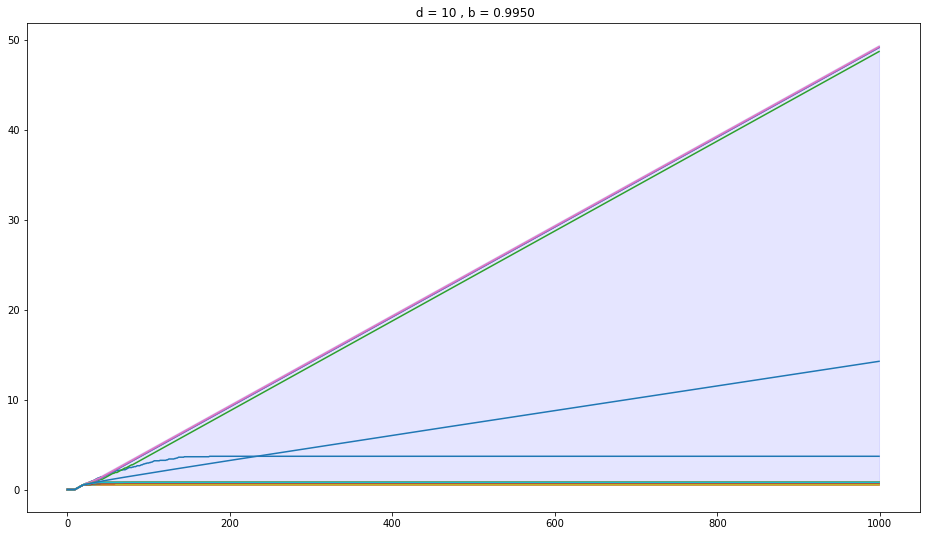

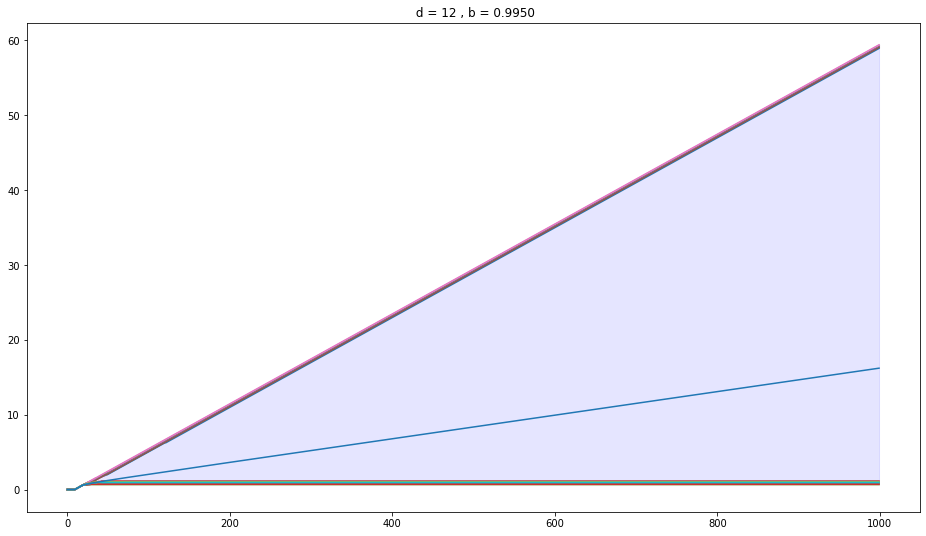

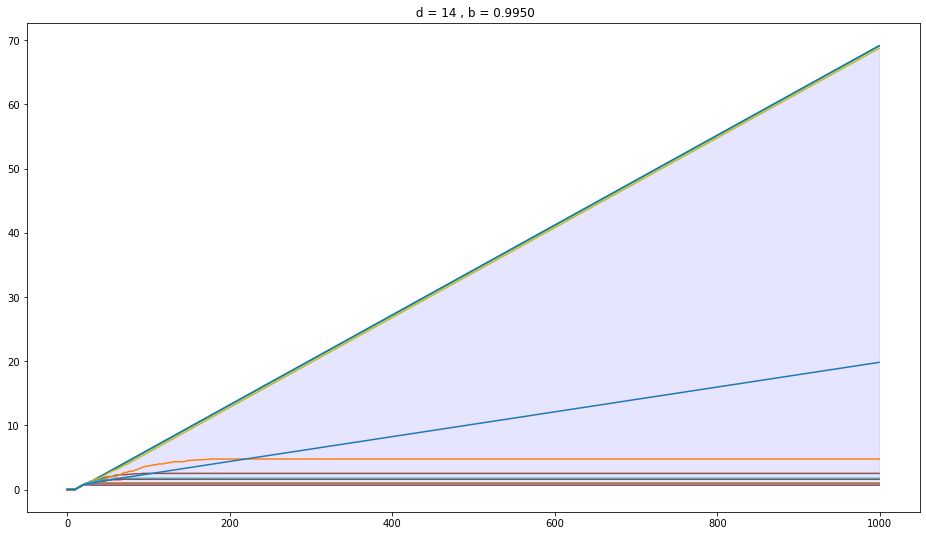

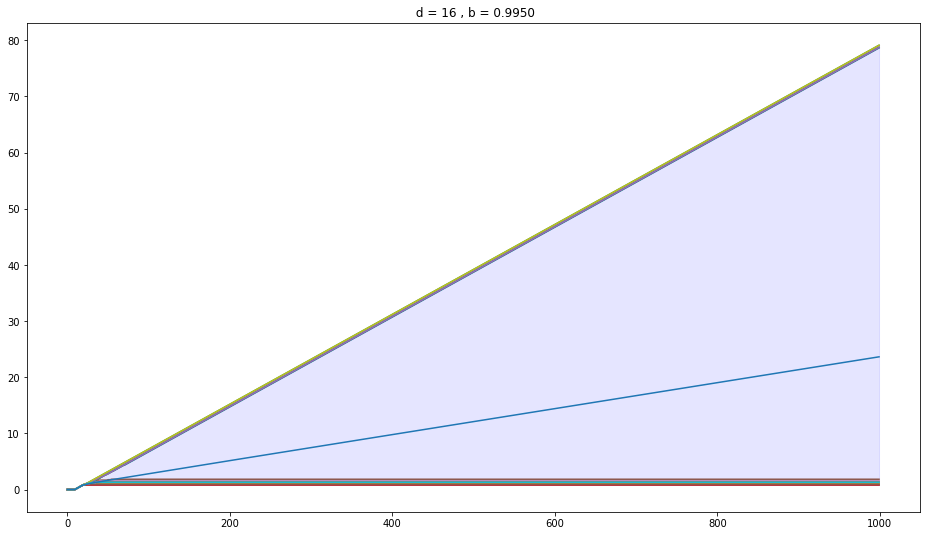

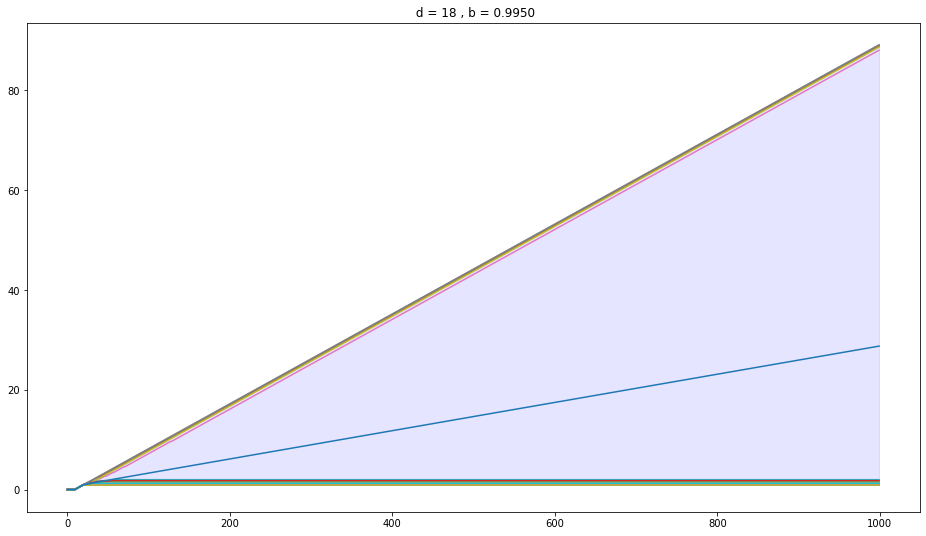

In [18]:
for i,d in enumerate(ds):
    plt.figure(i,figsize = (16,9))
    plt.clf()
    plt.title(" d = {} , b = {:.4f}".format(d,b))
    for k in np.random.randint(0,n_trial,20):
        plt.plot(cumulative_regrets[i,k,::])
    plt.plot(np.mean(cumulative_regrets[i,::,::],axis = 0))
    maxi95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.975)]
    maxi95 = cumulative_regrets[i,maxi95,::]
    
    mini95 = np.argsort(cumulative_regrets[i,::,-1])[int(n_trial*0.075)]
    mini95 = cumulative_regrets[i,mini95,::]
    
    plt.fill_between(range(upper_limit),mini95,maxi95, color='b', alpha=.1)


## ESCB

In [ ]:
class ESCB():
    """
    TS for the two decision environnement
    """
    def __init__(self, d,n_init = 0):
        
        self.iteration = 0
        self.d = d
    
        self.numplayed = np.zeros(2)
        
        self.mu = np.zeros(2*self.d)
        self.sigma = np.zeros(2*self.d)
        
        self.initialization = False
        
        self.n_init = n_init # sample n_init time each decision
        if self.n_init > 0:   
            self.initialization = True
        
        self.playhist = []
        
         
    def reset(self):
        self.iteration = 0
        self.weight_draw = np.zeros(2*d)
        self.numplayed = np.zeros(2)
        self.playhist = []
        
        if self.n_init > 0:   
            self.initialization = True
        
        
    def play(self):
        """
        This will drow a sample (arm played) using the parameters 

        """
        
        if self.iteration < self.n_init:
            self.decision = 0
            self.playhist.append(self.decision)
            return(self.decision)
        
        if self.iteration < 2*self.n_init:
            self.decision = 1
            self.playhist.append(self.decision)
            return(self.decision)
        else:       
            self.initialization = False
        
            
                    
        index_a = np.sum(self.mu[:self.d])+np.sqrt((np.log(self.iteration)+4*d*np.log(np.log(self.iteration)))/2*self.numplayed[0])
        index_b = np.sum(self.mu[self.d:])+np.sqrt((np.log(self.iteration)+4*d*np.log(np.log(self.iteration)))/2*self.numplayed[1])
        if index_a > index_b:
            self.decision = 0
        else :
            self.decision = 1
            
            
        self.playhist.append(self.decision)

        return self.decision


    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration += 1
        self.numplayed[self.decision] += 1
        
        if self.decision == 0:    
            self.mu[:self.d] = (self.mu[:self.d]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
            self.sigma[:self.d] =  1/np.sqrt(self.numplayed[self.decision])
        elif self.decision == 1:
            self.mu[self.d:] = (self.mu[self.d:]*(self.numplayed[self.decision]-1)+observation)/self.numplayed[self.decision]
            self.sigma[self.d:] =  1/np.sqrt(self.numplayed[self.decision])

In [ ]:
# testing the first time optimal is played

ds = range(10,20,2)
distrib_first_optimal = []
n_trial = 1000 
a=1
b=0.995
n_init = 20
random_variable = "bernoulli"

uper_limit = 200000
#n_iteration = 20000


for i,d in enumerate(ds):
    print("d = ",d)
    distrib_first_optimal.append([])
    
    for iteration in range(n_trial):
        if iteration%100 == 0:
            print("begin_trial {}".format(iteration))

        env = Two_decision_env(d,a = a,b = b,sigma = 1, random_variable = random_variable)
        player = ESCB(d,n_init = n_init, post_distrib = post_distrib)

        counter = 0
        while player.initialization:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
        
        while player.decision and counter < uper_limit:
                decision = player.play()
                reward_dict, regret = env.draw(decision)
                player.update(reward_dict)
                counter += 1

                if counter%2000 == 0:
                    print("Have still not played the optimal arm at time {}".format(counter))


        distrib_first_optimal[i].append(counter)   

# CUCB on choosing items

You have n item you can choose as many items as you want, some items as a negative reward other positve

In [65]:
# Create the bipartite graph matching environnement
class item_choosing():
    """
    create an environement with n items that have a either a positive or a negative reward
    n is the number of items
    k is the number of items with negative reward
    
    good item will have reward 1 bad, reward 1 (for the moment)
    
    """ 
    def __init__(self,n, random_weight = False ):
        self.d = n
        self.m = n 
        
        self.k = k
        
        # weight mean 
        self.mean_vector = np.ones(n)
        self.mean_vector[:k] = -1
        
        if random_weight:
            self.mean_vector = np.random.exponential(scale=1.0 n)*self.mean_vector
        
    def draw(self, arm_played):
        """
        Draw a vector of reward in a dict
        Also return the regret of that choice
        
        """
        reward_dict = dict()
        regret = np.sum(self.mean_vector[k:])
        # we assume for the moment that all arm are independent
        for i in arm_played:
            reward_dict[i] = norm.rvs(self.mean_vector[i])
            
            if i < self.k:
                regret -= self.mean_vector[i]
            else:
                regret -= self.mean_vector[i]
            
        return reward_dict, regret

In [80]:
class UCB_items():
    """
    Play the ecsb strategie on the item choosing game
    
    """
    def __init__(self, n):
        self.n = n
        
        self.mu = np.zeros(n)
        self.T = np.zeros(n)
        self.b = np.ones(n)
        
        self.iteration = 0
        
    def reset(self):
        self.iteration = 0
        self.T = 0
        self.b = np.ones(n)
        self.mu = np.zeros(self.n)
        
        
    def play(self):
        
        self.opti = self.mu + self.b
        arm_played = [i for i in range(self.n) if self.opti[i] >= 0]
        
        return arm_played
        
    def update(self, observation):
        """
        update the parameter of the arms
        observation are a dictionary of reward
        """
        self.iteration +=1
        for key, valu in observation.items():
            self.T[key] += 1
            self.mu[key] = (self.mu[key]*(self.T[key]-1)+valu)/self.T[key]
        
        self.b = np.sqrt(1.5*np.log(self.iteration)/self.T)
            
        
        
        
        
        
        

In [81]:
ns = [16,32,64,100,128]
n_trial = 2
all_regrets = []
mean_vectors = []

for n in ns:
    k = int(n/2)
    trial_regrets = []
    env = item_choosing(n,k)
    mean_vectors.append(env.mean_vector)
    for trial in range(n_trial):
        player = UCB_items(n)
        n_iteration = 3000
        regrets = []
        for i in range(n_iteration):
            arm_played = player.play()
            reward_dict, regret = env.draw(arm_played)
            regrets.append(regret)
            player.update(reward_dict)
        trial_regrets.append(regrets)
        
    all_regrets.append(trial_regrets)  

/Users/rzhang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


[9.42311705e-04 5.51421880e+00 2.13475577e+01]
[468.0146492]
[ 2.70610142e-04 -5.78342161e-02  9.05894776e+00 -3.01525755e+01]
[1.91019425]
[ 6.50284528e-07  8.37126843e-05 -3.99419533e-02  8.41474715e+00
 -2.32963185e+01]
[]


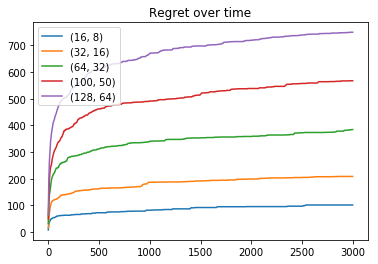

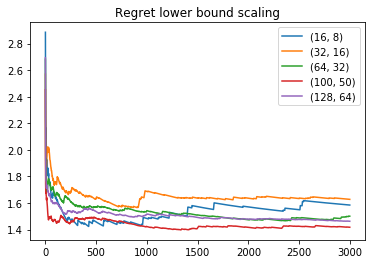

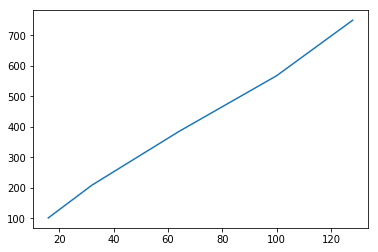

In [82]:
final_regrets = []
for i,n in enumerate(ns):
    k = int(n/2)
    cumulative_regrets = np.mean(np.cumsum(all_regrets[i],axis = 1),axis = 0)
    C = -np.sum(mean_vectors[i][:k])
    Domination_constant = cumulative_regrets[1:]/np.log(np.arange(1,len(cumulative_regrets)))/C
    final_regrets.append(cumulative_regrets[-1])
    plt.figure(1)
    plt.plot(cumulative_regrets, label = (n,k))
    plt.title("Regret over time")
    plt.legend()
    plt.figure(2)
    plt.plot(Domination_constant, label = (n,k))
    plt.title("Regret lower bound scaling")
    plt.legend()


plt.figure(3)
plt.clf()
plt.plot(ns,final_regrets)


# if we fit with polynomial of degree 2
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,2,full = True)
print(p)
print(residuals)

# if we fit with polynomial of degree 3
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,3,full = True)
print(p)
print(residuals)


# if we fit with polynomial of degree 4
p ,residuals, rank, singular_values, rcond = np.polyfit(np.array(ns),final_regrets,4,full = True)
print(p)
print(residuals)

In [37]:
final_regrets

[1800.0, 1800.0, 1800.0, 1810.0, 1800.0, 1800.0, 1800.0]

In [55]:
cumulative_regrets[1:1000]

array([ 81., 114., 146., 173., 197., 222., 247., 272., 294., 311., 327.,
       341., 351., 362., 376., 386., 394., 404., 412., 423., 429., 433.,
       439., 445., 450., 456., 460., 466., 472., 477., 481., 485., 492.,
       497., 503., 508., 513., 521., 526., 530., 534., 537., 538., 540.,
       540., 542., 544., 549., 552., 554., 555., 556., 558., 560., 560.,
       565., 566., 568., 572., 575., 577., 578., 580., 582., 584., 586.,
       588., 590., 593., 595., 595., 596., 596., 597., 597., 599., 600.,
       601., 602., 602., 603., 603., 603., 603., 603., 603., 605., 608.,
       611., 614., 616., 617., 618., 619., 620., 623., 624., 625., 626.,
       628., 629., 629., 630., 631., 632., 633., 635., 637., 637., 637.,
       638., 638., 638., 639., 640., 640., 640., 640., 640., 640., 643.,
       645., 647., 648., 650., 653., 655., 656., 660., 664., 666., 668.,
       669., 671., 673., 674., 675., 676., 678., 680., 681., 682., 685.,
       687., 690., 694., 695., 695., 697., 698., 69

# Dichotomy to compute solution 

## One strategy

$\sum_i^m\frac{1}{i+\alpha} = 1$

In [136]:
def function_harmo(alpha,m):
    c = np.arange(m)+alpha
    c = np.sum(1/c)-1
    return c

def dichotomie(f,m, eps = 10**-3):
    """
    return the solution for alpha, f(m,alpha) = 0
    """
    a = 1
    b = m
    while b-a > eps:
        c = (a+b)/2
        if f(c,m) <= 0:
            b = c
        else :
            a = c
    return c

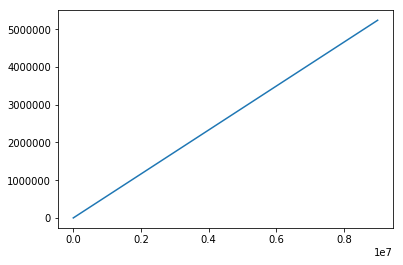

In [138]:
m_max = 100000
m_list = np.arange(2, 10000000 , 1000000)
solutions = np.zeros(m_list.shape)

for i,m in enumerate(m_list):
    solutions[i] = dichotomie(function_harmo,m)
    
plt.figure(1)
plt.plot(m_list,solutions)

In [139]:
solutions[:10]

array([1.61816406e+00, 5.81978371e+05, 1.16395508e+06, 1.74593178e+06,
       2.32790849e+06, 2.90988520e+06, 3.49186190e+06, 4.07383861e+06,
       4.65581532e+06, 5.23779203e+06])

In [123]:
np.sqrt(2)

1.4142135623730951

In [132]:
np.arange(0, 100000 , 1000)

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000, 50000, 51000, 52000, 53000,
       54000, 55000, 56000, 57000, 58000, 59000, 60000, 61000, 62000,
       63000, 64000, 65000, 66000, 67000, 68000, 69000, 70000, 71000,
       72000, 73000, 74000, 75000, 76000, 77000, 78000, 79000, 80000,
       81000, 82000, 83000, 84000, 85000, 86000, 87000, 88000, 89000,
       90000, 91000, 92000, 93000, 94000, 95000, 96000, 97000, 98000,
       99000])